Github of the project:

[https://github.com/szilvasipeter2000/Data-Analysis-2](https://github.com/szilvasipeter2000/Data-Analysis-2)

# Introduction
In response to the COVID-19 crisis, the U.S. Federal Government, led by the Trump administration in 2020, initiated the Paycheck Protection Program (PPP). Designed to support a range of entities including businesses, self-employed workers, nonprofits, and smaller enterprises, this program offered low-interest loans. Its primary objective was to aid in covering essential expenses such as payroll, rent, interest, and utilities. Notably, businesses that maintained stable employee numbers and wages had the opportunity for partial or complete loan forgiveness. This report seeks to explore how these loans were distributed.


## My research question: 
How do business ownership characteristics, specifically ethnicity, gender, veteran status, and political affiliation of the state, along with the proportion of Black residents in a state, collectively influence the loan amounts received through the Paycheck Protection Program?


In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
import statsmodels.api as sm

In [2]:
# import Gabor's helper functions
from py_helper_functions import *

## Data
To run my analysis, I collected my data from the Black Wealth Data Center website, and I enriched my data with political affiliation of state, by looking at the governor of the state in 2020 and his/her political party. I gathered this information from the website of Ballotpedia.


# Data Cleaning
The original dataset includes 1,206,970 observations as the geographical grouping of the data is broken down to state, county, and zip code level which results the file to take up too much memory for me to be able to push it to GitHub. To fix this, I have filtered down to only state level observations. I also excluded those observations which were unanswered in certain categories. In the end I overwrote the original file to save space.

This cleaning was done in `01_initial_cleaning_code_working.ipynb` which cannot be run again, as it overwrote the original file. 


In [3]:
# import data which is already filtered using the 01_filter_data.ipynb file
df = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Analysis-2/main/data/loan_data.csv')

# import political affiliation of states data
df_states = pd.read_csv('https://raw.githubusercontent.com/szilvasipeter2000/Data-Analysis-2/main/data/state_affiliation.csv',delimiter=';',header=None)

In [4]:
df_states.head()

,0,1,2
0,Alabama,R,NaN
1,Alaska,R,NaN
2,Arizona,R,NaN
3,Arkansas,R,NaN
4,California,D,NaN


In [5]:
# correct mistake in csv (drop empty column)
df_states.dropna(inplace=True,axis=1)

# rename columns
df_states.columns = ['geo_name','affiliation']

# merge dataframes
df = df.merge(df_states,on='geo_name')

---
# 00. EDA
--- 

In [6]:
df.head()

,geo_name,geo_level,race_or_ethnicity,gender,veteran,number_of_loans,loan_amount,quartiles_number_of_loans,quartiles_loan_amount,percentile_number_of_loans,percentile_loan_amount,pct_black_alone,affiliation
0,Montana,state,Hispanic,Female Owned,Veteran,8,376256,Bottom 25% of geographies,26-50% of geographies,22,30,0.6,R
1,Montana,state,Hispanic,Female Owned,Non-Veteran,96,2776646,Bottom 25% of geographies,Bottom 25% of geographies,12,10,0.6,R
2,Montana,state,White,Female Owned,Non-Veteran,2546,97370815,26-50% of geographies,Bottom 25% of geographies,30,22,0.6,R
3,Montana,state,White,Female Owned,Veteran,116,3037589,26-50% of geographies,Bottom 25% of geographies,28,18,0.6,R
4,Montana,state,Asian,Female Owned,Veteran,1,95000,Bottom 25% of geographies,Bottom 25% of geographies,0,19,0.6,R


In [7]:
print(f"I have {df.shape[0]} rows and {df.shape[1]} columns in my dataset.")

I have 807 rows and 13 columns in my dataset.


In [8]:
# look at columns
df.columns

Index(['geo_name', 'geo_level', 'race_or_ethnicity', 'gender', 'veteran',
       'number_of_loans', 'loan_amount', 'quartiles_number_of_loans',
       'quartiles_loan_amount', 'percentile_number_of_loans',
       'percentile_loan_amount', 'pct_black_alone', 'affiliation'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 807 entries, 0 to 806
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   geo_name                    807 non-null    object 
 1   geo_level                   807 non-null    object 
 2   race_or_ethnicity           807 non-null    object 
 3   gender                      807 non-null    object 
 4   veteran                     807 non-null    object 
 5   number_of_loans             807 non-null    int64  
 6   loan_amount                 807 non-null    int64  
 7   quartiles_number_of_loans   807 non-null    object 
 8   quartiles_loan_amount       807 non-null    object 
 9   percentile_number_of_loans  807 non-null    int64  
 10  percentile_loan_amount      807 non-null    int64  
 11  pct_black_alone             807 non-null    float64
 12  affiliation                 807 non-null    object 
dtypes: float64(1), int64(4), object(8)


In [10]:
# look at value counts for each column
for col in df.columns:
    print(df[col].value_counts())
    print('-------------------')

Montana                 16
North Carolina          16
Kentucky                16
South Carolina          16
New Mexico              16
Hawaii                  16
Colorado                16
Florida                 16
New Jersey              16
Alabama                 16
Georgia                 16
California              16
Washington              16
Pennsylvania            16
Massachusetts           16
New York                16
Ohio                    16
Oregon                  16
Mississippi             16
Illinois                16
West Virginia           16
Indiana                 16
Arkansas                16
Arizona                 16
Tennessee               16
Nevada                  16
South Dakota            16
Nebraska                16
Louisiana               16
Kansas                  16
Connecticut             16
Idaho                   16
Michigan                16
Virginia                16
Utah                    16
Maryland                16
District of Columbia    16
T

In [11]:
# look at the unique values of each column
for col in df.columns:
    print(col, df[col].nunique())

geo_name 51
geo_level 1
race_or_ethnicity 4
gender 2
veteran 2
number_of_loans 577
loan_amount 807
quartiles_number_of_loans 4
quartiles_loan_amount 4
percentile_number_of_loans 90
percentile_loan_amount 91
pct_black_alone 49
affiliation 2


In [12]:
# look at null values
df.isnull().sum()

geo_name                      0
geo_level                     0
race_or_ethnicity             0
gender                        0
veteran                       0
number_of_loans               0
loan_amount                   0
quartiles_number_of_loans     0
quartiles_loan_amount         0
percentile_number_of_loans    0
percentile_loan_amount        0
pct_black_alone               0
affiliation                   0
dtype: int64

In [13]:
# descriptive table
df.describe()

,number_of_loans,loan_amount,percentile_number_of_loans,percentile_loan_amount,pct_black_alone
count,807.000000,8.070000e+02,807.000000,807.000000,807.000000
mean,3014.047088,1.625656e+08,49.784387,50.000000,11.270012
std,7259.171822,5.263416e+08,29.641708,29.477333,10.408518
min,1.000000,3.010000e+02,0.000000,0.000000,0.600000
25%,53.500000,1.992810e+06,24.000000,24.000000,3.400000
50%,339.000000,1.562447e+07,50.000000,50.000000,7.300000
75%,1949.500000,9.952855e+07,76.000000,76.000000,15.200000
max,73256.000000,8.835301e+09,100.000000,100.000000,44.700000


## Look at loan amount as our dependent variable

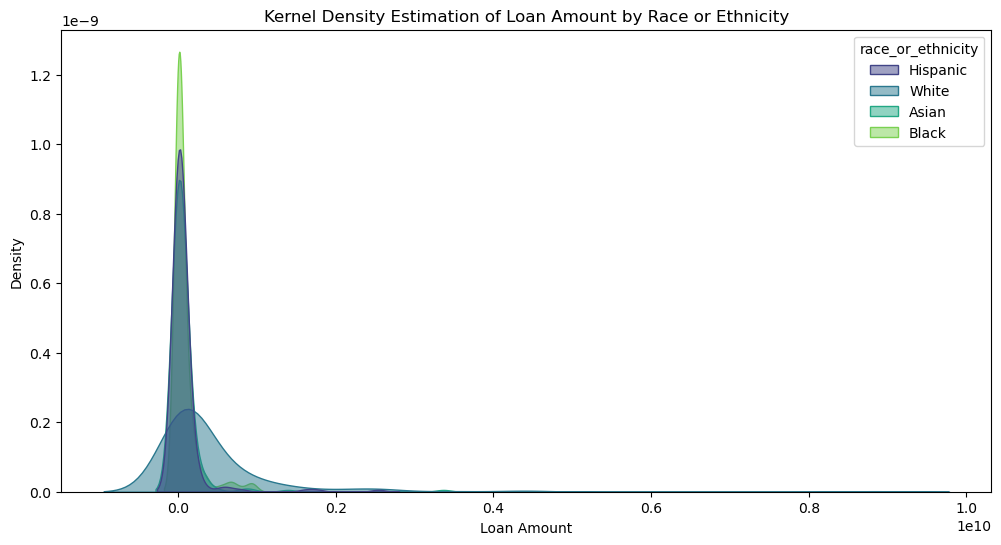

In [14]:
# Setting up the size of figure
plt.figure(figsize=(12, 6))

# Create the KDE plot
sns.kdeplot(data=df, x='loan_amount', hue='race_or_ethnicity', 
            palette='viridis',  # color palette
            fill=True,  # fill the area under the curve
            alpha=0.5)  # transparency

# Set labels and title
plt.xlabel('Loan Amount')
plt.title('Kernel Density Estimation of Loan Amount by Race or Ethnicity')

# Show the plot
plt.show()

In [15]:
# Log transform the loan_amount column
df['ln_loan_amount'] = df['loan_amount'].apply(lambda x: np.log(x))

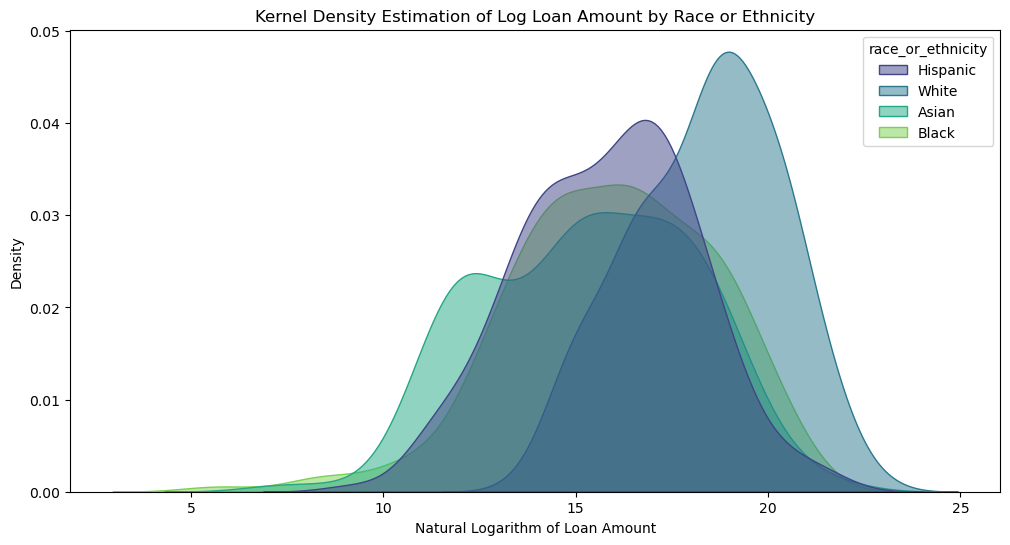

In [16]:
# Setting up the figure
plt.figure(figsize=(12, 6))

# Create the KDE plot
sns.kdeplot(data=df, x='ln_loan_amount', hue='race_or_ethnicity', 
            palette='viridis',  # color palette
            fill=True,  # fill the area under the curve
            alpha=0.5)  # transparency

# Set labels and title
plt.xlabel('Natural Logarithm of Loan Amount')
plt.title('Kernel Density Estimation of Log Loan Amount by Race or Ethnicity')

# Show the plot
plt.show()

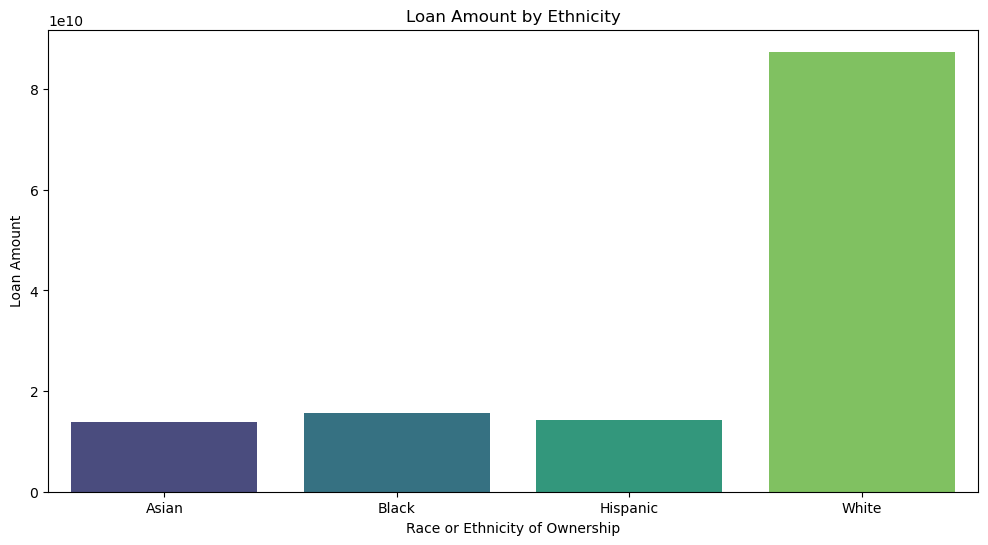

In [17]:
# create a dataframe with the log loan amount grouped by ehnicity
by_ethnicity = df.groupby(by='race_or_ethnicity').aggregate({'loan_amount': ['sum']}).reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=by_ethnicity,x='race_or_ethnicity',y=('loan_amount','sum'), # multiindex header
            palette='viridis')
# Set labels and title
plt.xlabel('Race or Ethnicity of Ownership') 
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Ethnicity')

plt.show()

## Look at controlling variables

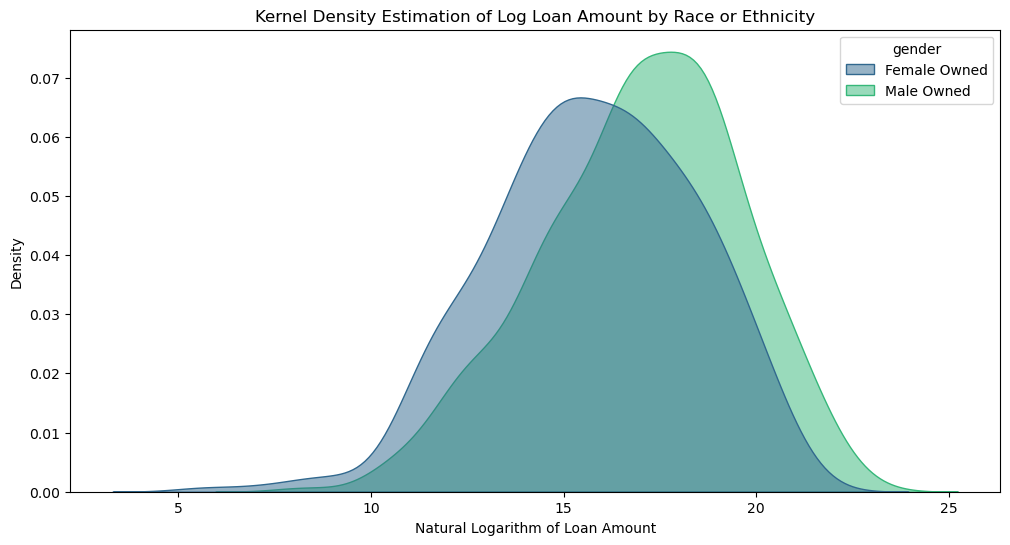

In [18]:
# Setting up the figure
plt.figure(figsize=(12, 6))

# Create the KDE plot
sns.kdeplot(data=df, x='ln_loan_amount', hue='gender',
            palette='viridis',  # Color palette
            fill=True,  # Fill the area under the curve
            alpha=0.5)  # transparency

# Set labels and title
plt.xlabel('Natural Logarithm of Loan Amount')
plt.title('Kernel Density Estimation of Log Loan Amount by Race or Ethnicity')

# Show the plot
plt.show()

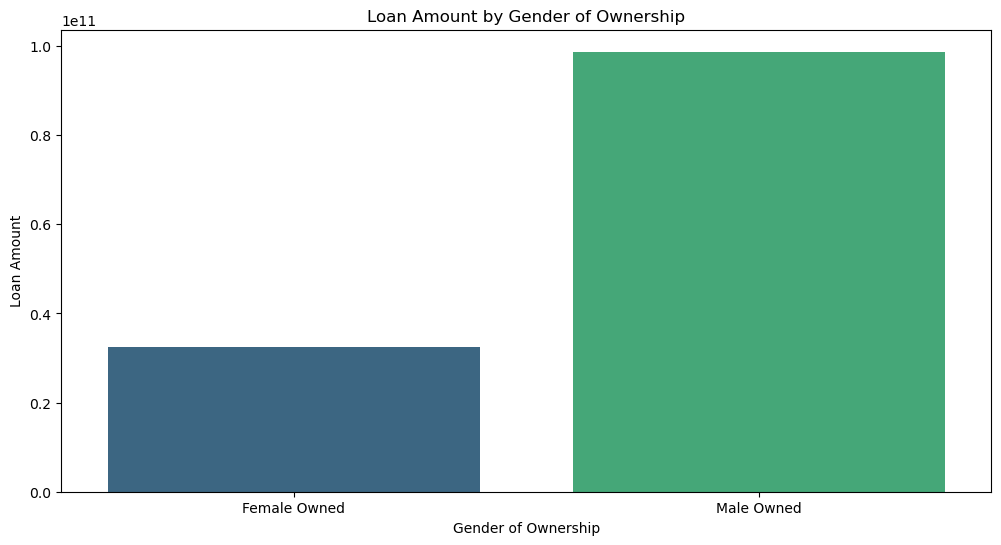

In [19]:
# create a DataFrame with the loan amount grouped by gender
by_gender = df.groupby(by='gender').aggregate({'loan_amount': ['sum']}).reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=by_gender, x='gender', y=('loan_amount', 'sum'), palette='viridis')

# Set labels and title
plt.xlabel('Gender of Ownership')
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Gender of Ownership')

plt.show()

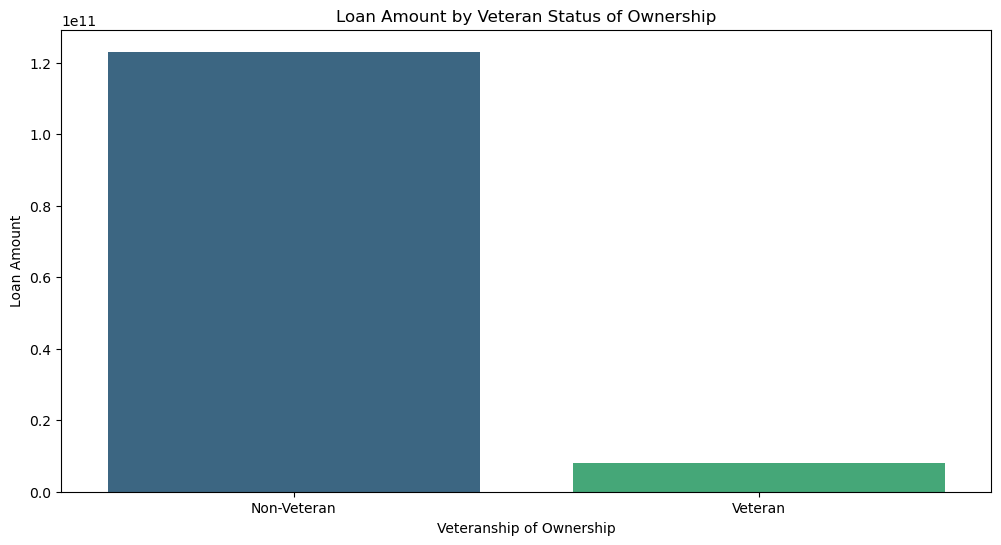

In [20]:
# create a DataFrame with the loan amount grouped by veteran status
by_veteranship = df.groupby(by='veteran').aggregate({'loan_amount': ['sum']}).reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=by_veteranship, x='veteran', y=('loan_amount', 'sum'), palette='viridis')

# Set labels and title
plt.xlabel('Veteranship of Ownership')
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Veteran Status of Ownership')

plt.show()

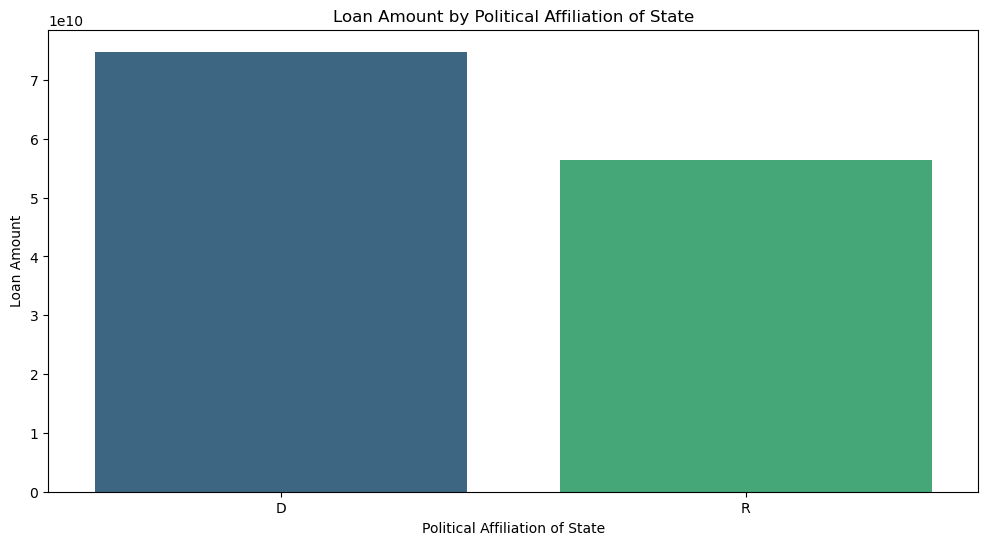

In [21]:
# create a DataFrame with the loan amount grouped by political affiliation of state
by_affiliation = df.groupby(by='affiliation').aggregate({'loan_amount': ['sum']}).reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=by_affiliation, x='affiliation', y=('loan_amount', 'sum'), palette='viridis')

# Set labels and title
plt.xlabel('Political Affiliation of State')
plt.ylabel('Loan Amount')
plt.title('Loan Amount by Political Affiliation of State')

plt.show()

C:\Users\Peti\AppData\Local\Temp\ipykernel_29468\2796172074.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


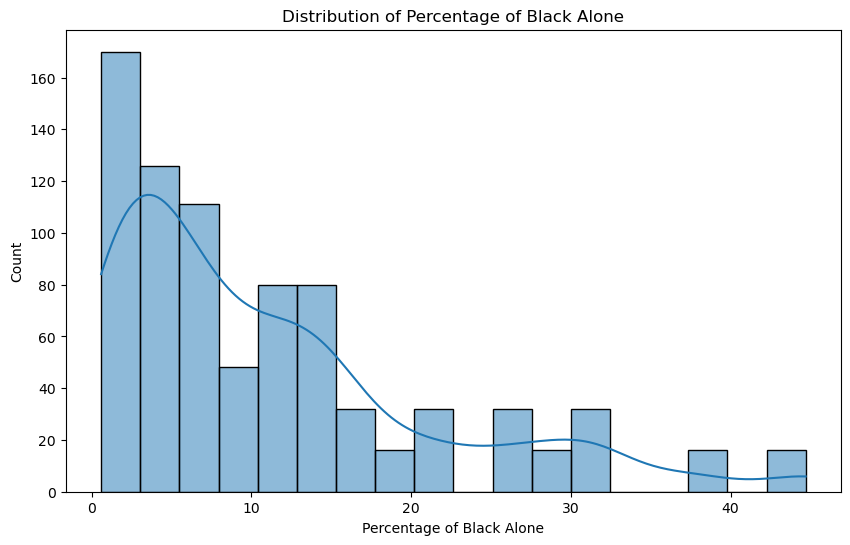

In [22]:
# create a histogram of the percentage of black alone
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='pct_black_alone', kde=True,palette='viridis')

# Set labels and title
plt.xlabel('Percentage of Black Alone')
plt.ylabel('Count')
plt.title('Distribution of Percentage of Black Alone')

plt.show()

# Create Dummy Variables

In [23]:
# creating dummy variables
# for white owned businesses
df['white_owned'] = df['race_or_ethnicity'].apply(lambda x: 1 if x == 'White' else 0)

# for male owned businesses
df['male_owned'] = df['gender'].apply(lambda x: 1 if x == 'Male Owned' else 0)

# for Non-Veteran owned businesses
df['nonveteran_owned'] = df['veteran'].apply(lambda x: 1 if x == 'Non-Veteran' else 0)

# for Republican states
df['republican'] = df['affiliation'].apply(lambda x: 1 if x == 'R' else 0)

# for ln number of loans
df['ln_number_of_loans'] = df['number_of_loans'].apply(lambda x: np.log(x))

C:\Users\Peti\AppData\Local\Temp\ipykernel_29468\2727668358.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


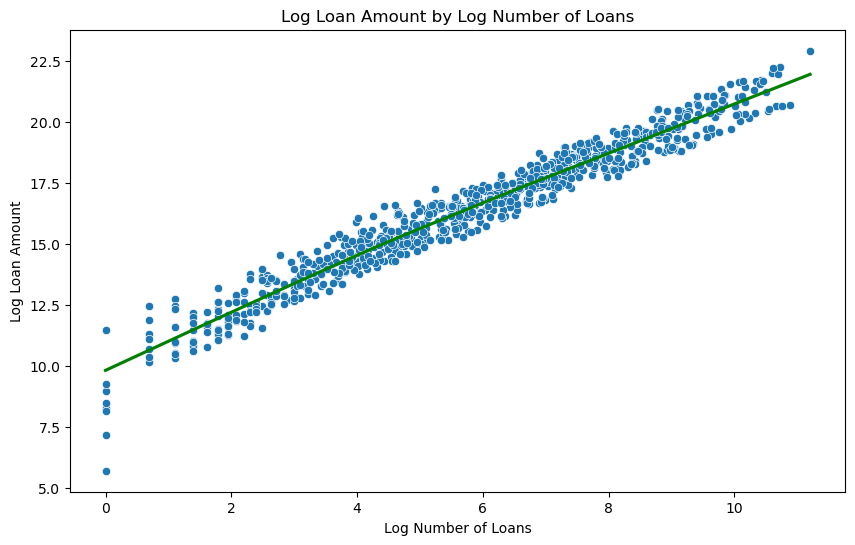

In [24]:
# check if number of loans is a good control
# check for potential splines
plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(data=df, x='ln_number_of_loans', y='ln_loan_amount', palette='viridis')
sns.regplot(data=df, x='ln_number_of_loans', y='ln_loan_amount', lowess=True, scatter=False, color='green')

# Set labels and title
plt.xlabel('Log Number of Loans')
plt.ylabel('Log Loan Amount')
plt.title('Log Loan Amount by Log Number of Loans')


plt.show()

In [25]:
#I will leave this out of my model, as they are in perfect collinearity.

In [26]:
# descriptive table for the variables I will use in my model
df[['loan_amount','ln_loan_amount','white_owned','male_owned','nonveteran_owned','republican','pct_black_alone']].describe()

,loan_amount,ln_loan_amount,white_owned,male_owned,nonveteran_owned,republican,pct_black_alone
count,8.070000e+02,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000
mean,1.625656e+08,16.364816,0.252788,0.501859,0.505576,0.525403,11.270012
std,5.263416e+08,2.696700,0.434880,0.500307,0.500279,0.499664,10.408518
min,3.010000e+02,5.707110,0.000000,0.000000,0.000000,0.000000,0.600000
25%,1.992810e+06,14.505031,0.000000,0.000000,0.000000,0.000000,3.400000
50%,1.562447e+07,16.564349,0.000000,1.000000,1.000000,1.000000,7.300000
75%,9.952855e+07,18.415929,1.000000,1.000000,1.000000,1.000000,15.200000
max,8.835301e+09,22.902021,1.000000,1.000000,1.000000,1.000000,44.700000


In [27]:
# Create Descriptive Table of binary variables to later inlcude in the documentation
# look at binary variables
series1 = df['white_owned'].value_counts()
series2 = df['male_owned'].value_counts()
series3 = df['nonveteran_owned'].value_counts()
series4 = df['republican'].value_counts()

#create DataFrame
value_counts_table = pd.DataFrame({'White Owned': series1, 'Male Owned': series2, 'Non-Veteran Owned': series3, 'Republican': series4})
value_counts_table.index = ['No', 'Yes'] # rename index

# add new row
value_counts_table.loc['Percentage of Total'] = value_counts_table.loc["Yes"]/(value_counts_table.sum()) # calculate percentage of total
value_counts_table.loc['Percentage of Total'] = value_counts_table.loc['Percentage of Total'].apply(lambda x: "{:.2%}".format(x)) # format as percentage
value_counts_table.round(2).T # transpose and round to 2 decimals

,No,Yes,Percentage of Total
White Owned,603.0,204.0,25.28%
Male Owned,402.0,405.0,50.19%
Non-Veteran Owned,399.0,408.0,50.56%
Republican,383.0,424.0,52.54%


In [28]:
# Create Descriptive Table of continous variables to later inlcude in the documentation
df[['loan_amount','ln_loan_amount','pct_black_alone']].describe().round(2)


,loan_amount,ln_loan_amount,pct_black_alone
count,8.070000e+02,807.00,807.00
mean,1.625656e+08,16.36,11.27
std,5.263416e+08,2.70,10.41
min,3.010000e+02,5.71,0.60
25%,1.992810e+06,14.51,3.40
50%,1.562447e+07,16.56,7.30
75%,9.952855e+07,18.42,15.20
max,8.835301e+09,22.90,44.70


---
# Regression Models
--- 

In [29]:
# start with simple level-level regression
reg1 = smf.ols('loan_amount ~ white_owned', data=df).fit()
stargazer1 = Stargazer([reg1])
stargazer1.rename_covariates({'Intercept': 'Constant', 'white_owned': 'White Owned'})
stargazer1

In [30]:
# log might capture the relationship better
reg2 = smf.ols('ln_loan_amount ~ white_owned', data=df).fit()
stargazer2 = Stargazer([reg2])
stargazer2.rename_covariates({'Intercept': 'Constant', 'white_owned': 'White Owned'})
stargazer2

R-squared is higher so it's best to use log-level regression

In [31]:
# What is the percentage change, how to interpret log differences
# Calculate the beta coefficient
beta = reg2.params['white_owned']

# Compute the percentage change
percentage_change = (np.exp(beta) - 1) * 100

print(f"Percentage Change: {percentage_change:.2f}%")


Percentage Change: 1383.31%


In [32]:
# add binary controlling variables
reg3 = smf.ols('ln_loan_amount ~ white_owned + male_owned',data=df).fit()
reg4 = smf.ols('ln_loan_amount ~ white_owned + male_owned + nonveteran_owned',data=df).fit()
reg5 = smf.ols('ln_loan_amount ~ white_owned + male_owned + nonveteran_owned + republican', data=df).fit()
stargazer3 = Stargazer([reg2,reg3,reg4,reg5])
stargazer3.covariate_order(['white_owned','male_owned','nonveteran_owned','republican'])
stargazer3.rename_covariates({'Intercept': 'Constant', 'white_owned': 'White Owned','male_owned':'Male Owned','nonveteran_owned':'Non-Veteran Owned','republican':'Republican'})
stargazer3

In this Model, the constant indicates the average natural logarithm of loan amount for businesses not white-owned is 15.683. The "White Owned" coefficient suggests a 99% confidence that when the variable changes from 0 to 1, the ln loan amount rises by 2.697, equivalent to a 1383.31% increase. The R2 indicates 18.9% variability in the dependent variable is influenced by ownership status. However, the model’s Residual Error is considerably high, as we are looking at logarithmic values. To perfect the model, we can include controlling variables. In models, (2), (3), and (4), I included step-by-step one more variable to our model to see how each of them effect our dependent variable. All our controlling variables’ coefficients are statistically significant at 99% confidence level.

In [33]:
# add black population percentage of state as a control
reg6 = smf.ols("ln_loan_amount ~ white_owned + male_owned + nonveteran_owned + republican + pct_black_alone", data=df).fit(cov_type="HC1")
stargazer4 = Stargazer([reg3,reg4,reg5,reg6])
stargazer4.covariate_order(['white_owned','male_owned','nonveteran_owned','republican','pct_black_alone'])
stargazer4.rename_covariates({'Intercept': 'Constant', 'white_owned': 'White Owned','male_owned':'Male Owned','nonveteran_owned':'Non-Veteran Owned','republican':'Republican','pct_black_alone':'Percentage of Black Population'})
stargazer4

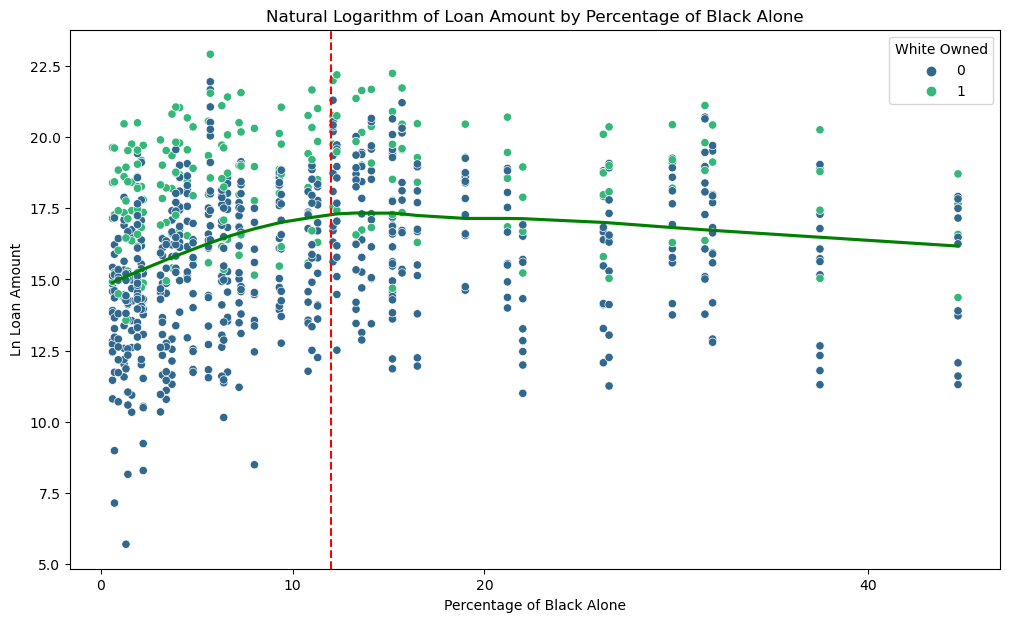

In [34]:
# Crate Plot to show the relationship between the percentage of black population and the log loan amount, and show which ones are white owned
plt.figure(figsize=(12, 7))

# Create the scatter plot's main layer
sns.scatterplot(data=df, x='pct_black_alone', y='ln_loan_amount', hue='white_owned',# show also which ones are white owned
                 palette='viridis')
# Create the scatter plot's lowess
sns.regplot(data=df, x='pct_black_alone', y='ln_loan_amount', lowess=True, scatter=False, color='green')

# Set labels and title
plt.xlabel('Percentage of Black Alone')
plt.ylabel('Ln Loan Amount')
plt.title('Natural Logarithm of Loan Amount by Percentage of Black Alone')

# Rename the legend
plt.legend(title='White Owned')

# set the ticks on the x axis
plt.xticks([0,10, 20, 40])

# Add vertical line at x=12
plt.axvline(x=12, color='red', linestyle='--')

plt.show()

In [35]:
# add piecewise lienar spline with knot at 12% black alone
reg7 = smf.ols("ln_loan_amount ~ white_owned + male_owned + nonveteran_owned + republican + lspline(pct_black_alone, [12])", data=df).fit(cov_type="HC1")
stargazer5 = Stargazer([reg6,reg7])
stargazer5.covariate_order(['white_owned','male_owned','nonveteran_owned','republican','lspline(pct_black_alone, [12])[0]','lspline(pct_black_alone, [12])[1]'])
# rename all covariates
stargazer5.rename_covariates({'white_owned':'White Owned', 'male_owned':'Male Owned', 'nonveteran_owned':'Non-Veteran Owned', 'republican':'Republican', 'lspline(pct_black_alone, [12])[0]':'Black Population < 12%', 'lspline(pct_black_alone, [12])[1]':'Black Population >= 12%'})
stargazer5

In [36]:
# check for interactions
reg8 = smf.ols("ln_loan_amount ~ white_owned + male_owned + nonveteran_owned + republican + white_owned * male_owned + lspline(pct_black_alone, [12])", data=df).fit(cov_type="HC1")
stargazer6 = Stargazer([reg8])
stargazer6.covariate_order(['white_owned','male_owned','nonveteran_owned','republican','white_owned:male_owned','lspline(pct_black_alone, [12])[0]','lspline(pct_black_alone, [12])[1]'])
# rename all covariates
stargazer6.rename_covariates({'white_owned':'White Owned', 'male_owned':'Male Owned', 'nonveteran_owned':'Non-Veteran Owned', 'republican':'Republican', 'white_owned:male_owned':'Interaction: White Male Owned', 'lspline(pct_black_alone, [12])[0]':'Black Population < 12%', 'lspline(pct_black_alone, [12])[1]':'Black Population >= 12%'})
stargazer6


In [37]:
reg8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_loan_amount   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     308.0
Date:                Sat, 23 Dec 2023   Prob (F-statistic):          5.57e-222
Time:                        18:08:40   Log-Likelihood:                -1409.9
No. Observations:                 807   AIC:                             2836.
Df Residuals:                     799   BIC:                             2873.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            12.0987      0.168     71.896      0.000      11.769      12.428
white_owned                           2.4101      0.126     19.137      0.000       2.163       2.657
male_owned                            1.0863      0.124      8.761      0.000       0.843       1.329
nonveteran_owned                      3.2891      0.099     33.328      0.000       3.096       3.483
republican                           -0.4365      0.102     -4.296      0.000      -0.636      -0.237
white_owned:male_owned                0.6638      0.179      3.706      0.000       0.313       1.015
lspline(pct_black_alone, [12])[0]     0.2393      0.013     18.151      0.000       0.213       0.265
lspline(pct_black_alone, [12])[1]    -0.0530      0.007     -7.109      0.000      -0.068      -0.038
==============================================================================
Omnibus:                       20.314   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.297
Skew:                          -0.038   Prob(JB):                     6.54e-10
Kurtosis:                       4.119   Cond. No.                         59.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [38]:
# to help with the percentage change interpretation
percentage_changes = (np.exp(reg8.params) - 1) * 100

for coefficient, percentage_change in zip(reg8.params.index, percentage_changes):
    print(f"Percentage Change for {coefficient}: {percentage_change:.2f}%")


Percentage Change for Intercept: 17962866.04%
Percentage Change for white_owned: 1013.53%
Percentage Change for male_owned: 196.33%
Percentage Change for nonveteran_owned: 2581.96%
Percentage Change for republican: -35.37%
Percentage Change for white_owned:male_owned: 94.21%
Percentage Change for lspline(pct_black_alone, [12])[0]: 27.04%
Percentage Change for lspline(pct_black_alone, [12])[1]: -5.16%


In [39]:
# don't interpret the intercept

My final regression, includes all previously discussed variables and shows key insights into how the loans were distributed. White, Male, Non-Veteran are in all positive correlation with the Loan Amounts. If we are looking at loans with the same characteristics, White Owned Businesses tend to get 1013.53%, Male 196.33%, and Non-Veteran Businesses 2581% more loans on average than those that are Non-white, female or veteran owned. Additionally White Male owned businesses got 94.20% more loans than those that are not White Male owned. Interestingly when looking at Republican and Democratic states, Republican ones got on average 35.37% less loans than Democratic states. As for Black Population, there was a positive correlation until 12% as anticipated. On average, in states where the percentage of black population is less than 12%, 1% more black people means an increase of loan amounts by 27.04%.  This trend changes above 12%, to -5.16%. Note that all these values are valid within a 99% confidence interval. The R-squared of the model is also quite high with 0.73 while our Residual Error is also lower than what we saw in Model 1 meaning that including splines and interaction was a good addition to the regression.

# Conclusion
To address the question of how different business ownership traits affect the distribution of Paycheck Protection Program (PPP) loans, Model 2 provided significant insights. White, Male, and Non-Veteran owned businesses stood out, receiving notably higher loan amounts under the Trump administration's PPP. This points to a clear inequality within the dataset. Even though all the coefficients are 99% statistically significant and we should be able generalize to the population our data represents, this is as far this dataset takes us. We do not have data about the percentage of white businesses, compared to other ethnic groups, just as we do not have information who applied for these loans and who got it. Nevertheless, the results show that grouped by states and ownership characteristics, White, Male, and Non-veteran businesses received an advantage in times of aid from the Trump Administration.
